In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd '/content/drive/MyDrive/Colab Notebooks'

/content/drive/MyDrive/Colab Notebooks


In this notebook, we follow the method given in a tutorial to perform data classification with neural network, in order to achieve the step 2 of our project.
We use our own dataset, composed of 3 multispectral images from Sentinel2 with 10 bands, and with labels that we create.
These images were downloaded with Google Earth Engine by running the notebook "Create sat images and OSD shapes V3.ipynb". 

# Packages installation

In [ ]:
!pip install rasterio

     |████████████████████████████████| 19.3MB 151kB/s 


In [ ]:
!pip install pyrsgis

# Neural network for satellite data classification
Reference tutorial: https://towardsdatascience.com/neural-network-for-satellite-data-classification-using-tensorflow-in-python-a13bcf38f3e1

In [ ]:
import os
import numpy as np
from tensorflow import keras

In [ ]:
from pyrsgis import raster
from pyrsgis.convert import changeDimension

Warning! matplotlib_scalebar library not found. You may not be able to export map directly.


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.utils import shuffle

For pixel-wise detection, we don't need a big dataset, as each pixel of one image represents one sample. Here we take two multispectral images for training: one from a dense urban areas, and the other from a dense nature area. 

In [ ]:
# Assign file names
images_dir = "/content/drive/MyDrive/how-green-is/sat_images/places"
featuresFile_urban = images_dir + '/sentinel2_Puebla_Mexico-98.281803__18-98.281803__18.979351_-98.140182__19.099431/sentinel2_image_cropped.tif'
featuresFile_nature = images_dir + '/sentinel2_Popocatepetl_7_Camino_Rojo_-98.731384__19.110136_-98.55835___19.312439/sentinel2_image_cropped.tif' 
featuresFile_mx = images_dir + '/sentinel2_Tlaxcala_Mexico-98.292789__19.282628_-98.188248__19.374312/sentinel2_image_cropped.tif'

In [ ]:
labelsFile_urban = images_dir + '/sentinel2_Puebla_Mexico-98.281803__18-98.281803__18.979351_-98.140182__19.099431/labels.tif'
labelsFile_nature = images_dir + '/sentinel2_Popocatepetl_7_Camino_Rojo_-98.731384__19.110136_-98.55835___19.312439/labels.tif' 
labelsFile_mx = images_dir + '/sentinel2_Tlaxcala_Mexico-98.292789__19.282628_-98.188248__19.374312/labels.tif'

To get numpy arrays from the multibands images, we can either use raster or rasterio

In [ ]:
import rasterio as rio

In [ ]:
# Read the rasters as array
ds1, featuresUrbanArea = raster.read(featuresFile_urban, bands='all')
ds2, featuresNatureArea = raster.read(featuresFile_nature, bands='all')

# We get 3D numpy arrays, with dimensions [band, row, col]
print(featuresUrbanArea.shape)  
print(featuresNatureArea.shape)  

(10, 1337, 1578)
(10, 2253, 1927)


In [ ]:
# We use rasterio to open the label files:
with rio.open(labelsFile_urban, 'r') as img:
  labelsUrbanArea = img.read(1)   
with rio.open(labelsFile_nature, 'r') as img:
  labelsNatureArea = img.read(1)  

print(labelsUrbanArea.shape)  
print(labelsNatureArea.shape)

(1337, 1578)
(2253, 1927)


Check the metadata to see what is the Coordinate Reference System (CRS) and the value of the nodata pixels

In [ ]:
with rio.open(featuresFile_urban, 'r') as img:
  print(img.meta)

{'driver': 'GTiff', 'dtype': 'float64', 'nodata': None, 'width': 1578, 'height': 1337, 'count': 10, 'crs': CRS.from_epsg(4326), 'transform': Affine(8.983152841195215e-05, 0.0, -98.28189045813608,
       0.0, -8.983152841195215e-05, 19.099440581778794)}


In [ ]:
nBands = featuresUrbanArea.shape[0]

In [ ]:
# Reshape the arrays to single dimensional arrays
featuresUrbanArea = changeDimension(featuresUrbanArea)
labelsUrbanArea = changeDimension (labelsUrbanArea)

print("Area Multispectral Urban image shape: ", featuresUrbanArea.shape)
print("Area Binary Urban image shape: ", labelsUrbanArea.shape)

Area Multispectral Urban image shape:  (2109786, 10)
Area Binary Urban image shape:  (2109786,)


In [ ]:
featuresNatureArea = changeDimension(featuresNatureArea)
labelsNatureArea = changeDimension (labelsNatureArea)

print("Area Multispectral Nature image shape: ", featuresNatureArea.shape)
print("Area Binary Nature image shape: ", labelsNatureArea.shape)

Area Multispectral Nature image shape:  (4341531, 10)
Area Binary Nature image shape:  (4341531,)


As the geotiff images are rectangle images, but the area of interest has been croped, the numpy arrays contain nodata pixels (in our case they have value 0). We need to remove them for training.

In [ ]:
def suppress_nodata_pixels(features, labels):
  # Suppress the nodata pixels (none = 0)
  total_nodata = 0
  feat = np.zeros((features.shape[0],features.shape[1]),dtype=np.int64)
  lab = np.zeros(labels.shape[0],dtype=np.int64)
  k = 0
  for i in range(features.shape[0]):
    if features[i,0] != 0:
      feat[k,:] = featuresArea[i,:]
      lab[k] = labels[i,]
      k = k + 1
    else :
      total_nodata = total_nodata + 1
  
  features = feat[0:k,:]
  labels = lab[0:k]
  print("total pixels suppressed:",total_nodata)

In [ ]:
suppress_nodata_pixels(featuresNatureArea, labelsNatureArea)

total pixels suppressed: 1053080


In [ ]:
suppress_nodata_pixels(featuresUrbanArea, labelsUrbanArea)

total pixels suppressed: 597732


Then we concatenate the 2 urban and nature feature arrays (respectively 2 labels arrays) and shuffle them before entry of NN.

In [ ]:
# Concatenate arrays
featuresArea = np.concatenate((featuresUrbanArea, featuresNatureArea))
labelsArea = np.concatenate((labelsUrbanArea, labelsNatureArea))  

In [ ]:
# Print the size of the arrays
print("Train/test area Multispectral image shape: ", featuresArea.shape)
print("Area Binary built-up image shape: ", labelsArea.shape)

Train/test area Multispectral image shape:  (6451317, 10)
Area Binary built-up image shape:  (6451317,)


In [ ]:
# Shuffle the arrays
featuresArea, labelsArea = shuffle(featuresArea, labelsArea, random_state=0)

In [ ]:
# Split testing and training datasets
xTrain, xTest, yTrain, yTest = train_test_split(featuresArea, labelsArea, test_size=0.4, random_state=42)

print(xTrain.shape)
print(yTrain.shape)

print(xTest.shape)
print(yTest.shape)

(3870790, 10)
(3870790,)
(2580527, 10)
(2580527,)


In [ ]:
# Check whether data is on 8 bits or 16 bits:
# 8 bits -> normalise by 255.0
# 16 bits -> normalise by 65535.0
featuresArea.max()

12041

In [ ]:
# Normalise the data
xTrain = xTrain / 65535.0
xTest = xTest / 65535.0

# Reshape the data
xTrain = xTrain.reshape((xTrain.shape[0], 1, xTrain.shape[1]))
xTest = xTest.reshape((xTest.shape[0], 1, xTest.shape[1]))

# Print the shape of reshaped data
print(xTrain.shape, xTest.shape)

(3870790, 1, 10) (2580527, 1, 10)


In [ ]:
# Define the parameters of the model
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(1, nBands)),
    keras.layers.Dense(14, activation='relu'),
    keras.layers.Dense(2, activation='softmax')])

# Define the accuracy metrics and parameters
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])


In [ ]:
# Run the model
model.fit(xTrain, yTrain, epochs=5)

Epoch 1/5
120963/120963 [==============================] - 211s 2ms/step - loss: 0.1655 - accuracy: 0.9426
Epoch 2/5
120963/120963 [==============================] - 209s 2ms/step - loss: 0.1347 - accuracy: 0.9515
Epoch 3/5
120963/120963 [==============================] - 209s 2ms/step - loss: 0.1278 - accuracy: 0.9533
Epoch 4/5
120963/120963 [==============================] - 203s 2ms/step - loss: 0.1234 - accuracy: 0.9543
Epoch 5/5
120963/120963 [==============================] - 205s 2ms/step - loss: 0.1196 - accuracy: 0.9551


In [ ]:
# Predict for test data 
yTestPredicted = model.predict(xTest)
yTestPredicted = yTestPredicted[:,1]

# Calculate and display the error metrics
yTestPredicted = (yTestPredicted>0.5).astype(int)
cMatrix = confusion_matrix(yTest, yTestPredicted)
pScore = precision_score(yTest, yTestPredicted)
rScore = recall_score(yTest, yTestPredicted)

print("Confusion matrix: for 14 nodes\n", cMatrix)
print("\nP-Score: %.3f, R-Score: %.3f" % (pScore, rScore))

Confusion matrix: for 14 nodes
 [[1217276   52051]
 [  65340 1245860]]

P-Score: 0.960, R-Score: 0.950


# Save model and test it with new data

In [ ]:
from keras.models import load_model

model.save('model_step2.h5')  # creates a HDF5 file
del model  # deletes the existing model

# returns a compiled model
# identical to the previous one
model = load_model('model_step2.h5')

In [ ]:
# Read the raster as array
ds3, featuresMxArea = raster.read(featuresFile_mx, bands='all')

# We get 3D numpy array, with dimensions [band, row, col]
print(featuresMxArea.shape)  

(10, 1021, 1165)


In [ ]:
# Reshape the array to single dimensional array
featuresMxArea = changeDimension(featuresMxArea)

In [ ]:
# Final image should be normalised as well
featuresMxArea = featuresMxArea / 65535.0

# Reshape the data
featuresMxArea = featuresMxArea.reshape((featuresMxArea.shape[0], 1, featuresMxArea.shape[1]))

# Print the shape of reshaped data
print("Final Area Multispectral image shape: ", featuresMxArea.shape)

Final Area Multispectral image shape:  (1189465, 1, 10)


In [ ]:
# Predict new data 
predicted = model.predict(featuresMxArea)
predicted = predicted[:,1]

# Export the probability raster
prediction = np.reshape(predicted, (ds3.RasterYSize, ds3.RasterXSize))
outFile = 'BuiltupNN_predicted.tif'
raster.export(prediction, ds3, filename=outFile, dtype='float')


# Visualisation of predicted images
Additional link to vizualise resulting .tif image

https://towardsdatascience.com/reading-and-visualizing-geotiff-images-with-python-8dcca7a74510

A GeoTIFF is a standard .tif or image file format that includes additional spatial (georeferencing) information embedded in the .tif file as tags

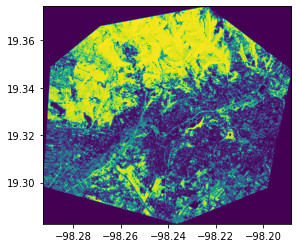

In [ ]:
import rasterio
from rasterio.plot import show
fp = r'BuiltupNN_predicted.tif'
img = rasterio.open(fp)
show(img)